# Power C100

In [530]:
import httpx
import socksio
from datetime import datetime, timedelta, timezone
import mplhep
import hist
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import json
import matplotlib.dates as mdates
import re
from concurrent.futures import ProcessPoolExecutor


## Download measurements from Prometheus

In [ ]:
queries = [
    ("gpu_power", "nvidia_power_watts", "1s"),
    ("bmc_power", 'ipmi_dcmi_power_consumption_watts{job="ipmi_g01"}', "1s"),
    (
        "cpu",
        '(sum by(instance) (irate(node_cpu_seconds_total{instance="ef-tb-g01:9100", mode !="idle"}[10s])) / on(instance) group_left sum by (instance)((irate(node_cpu_seconds_total[10s])))) * 100',
        "10s",
    ),
    (
        "cpu_freq",
        'avg(node_cpu_scaling_frequency_hertz{instance="ef-tb-g01:9100"})',
        "10s",
    ),
    (
        "cpu_freq_max",
        'max(node_cpu_scaling_frequency_hertz{instance="ef-tb-g01:9100"})',
        "10s",
    ),
    (
        "cpu_freq_min",
        'min(node_cpu_scaling_frequency_hertz{instance="ef-tb-g01:9100"})',
        "10s",
    ),
]

start_local = datetime(year=2025, month=6, day=17, hour=10, minute=0, second=0)
end_local = datetime(year=2025, month=6, day=17, hour=14, minute=30, second=0)

start = start_local.astimezone(timezone.utc)
end = end_local.astimezone(timezone.utc)

delta = timedelta(hours=3)
# end = datetime(year=2025, month=6, day=13, hour=10, minute=5, second=0, tzinfo=timezone.utc)

this_result = {}

with (
    httpx.Client(
        # proxy="socks5://localhost:8888",
    ) as client
):
    for key, query, step in queries:
        accumulated = []
        now = start
        while now < end:
            window_start = now.isoformat().replace("+00:00", "Z")
            window_end = min(end, now + delta).isoformat().replace("+00:00", "Z")
            print(window_start, window_end)
            now += delta

            url = "http://ef-tb-f01:9090/api/v1/query_range"
            r = client.get(
                url,
                params={
                    "query": query,
                    "start": window_start,
                    "end": window_end,
                    "step": step,
                },
            )
            print(r.url)
            data = r.json()
            values = data["data"]["result"][0]["values"]

            if len(accumulated) > 0:
                first_new, _ = values[0]
                last_existing, _ = accumulated[-1]
                if first_new == last_existing:
                    values = values[1:]  # drop the first value

            # print(values)
            accumulated += values

        this_result[key] = accumulated

fname = (
    Path.cwd()
    / f"result_{start_local:%Y-%m-%dT%H-%M-%S}__{end_local:%Y-%m-%dT%H-%M-%S}.json"
)

with fname.open("w") as f:
    json.dump(this_result, f)
print(fname)

2025-06-17T08:00:00Z 2025-06-17T11:00:00Z
http://ef-tb-f01:9090/api/v1/query_range?query=nvidia_power_watts&start=2025-06-17T08%3A00%3A00Z&end=2025-06-17T11%3A00%3A00Z&step=1s
2025-06-17T11:00:00Z 2025-06-17T12:30:00Z
http://ef-tb-f01:9090/api/v1/query_range?query=nvidia_power_watts&start=2025-06-17T11%3A00%3A00Z&end=2025-06-17T12%3A30%3A00Z&step=1s
2025-06-17T08:00:00Z 2025-06-17T11:00:00Z
http://ef-tb-f01:9090/api/v1/query_range?query=ipmi_dcmi_power_consumption_watts%7Bjob%3D%22ipmi_g01%22%7D&start=2025-06-17T08%3A00%3A00Z&end=2025-06-17T11%3A00%3A00Z&step=1s
2025-06-17T11:00:00Z 2025-06-17T12:30:00Z
http://ef-tb-f01:9090/api/v1/query_range?query=ipmi_dcmi_power_consumption_watts%7Bjob%3D%22ipmi_g01%22%7D&start=2025-06-17T11%3A00%3A00Z&end=2025-06-17T12%3A30%3A00Z&step=1s
2025-06-17T08:00:00Z 2025-06-17T11:00:00Z
http://ef-tb-f01:9090/api/v1/query_range?query=%28sum+by%28instance%29+%28irate%28node_cpu_seconds_total%7Binstance%3D%22ef-tb-g01%3A9100%22%2C+mode+%21%3D%22idle%22%7D%5B1

In [289]:
# result_file = Path.cwd() / "result.json"
# with result_file.open("w") as f:
#     json.dump(result, f)

# with result_file.open("r") as f:
# result = json.load(f)

In [489]:
result_files = [
    "result_2025-06-13.json",
    "result_2025-06-17T10-00-00__2025-06-17T14-30-00.json",
]

result = {}

for fname in result_files:
    with Path(fname).open("r") as f:
        data = json.load(f)
        for key, values in data.items():
            result.setdefault(key, []).extend(values)


## Build time series dataset from measurements

In [491]:
# result

In [ ]:
arr = np.array(result["bmc_power"]).T

print(arr)

bmc_times = np.array(arr[0], dtype=int)
bmc_power = np.array(arr[1], dtype=int)
bmc_times = pd.to_datetime(bmc_times, unit="s", utc=True)

arr = np.array(result["gpu_power"]).T

df_bmc = pd.DataFrame({"bmc_power": bmc_power})
df_bmc.index = bmc_times

gpu_times = np.array(arr[0], dtype=int)
gpu_power = np.array(arr[1], dtype=float)
gpu_times = pd.to_datetime(gpu_times, unit="s", utc=True)

df_gpu = pd.DataFrame({"gpu_power": gpu_power})
df_gpu.index = gpu_times

arr = np.array(result["cpu"]).T

cpu_times = np.array(arr[0], dtype=int)
cpu_perc = np.array(arr[1], dtype=float)
cpu_times = pd.to_datetime(cpu_times, unit="s", utc=True)


df_cpu = pd.DataFrame({"cpu": cpu_perc})
df_cpu.index = cpu_times

df = df_gpu.join(df_bmc).join(df_cpu)

df_cpu_freq = pd.DataFrame()

for q in ["cpu_freq", "cpu_freq_max", "cpu_freq_min"]:
    arr = np.array(result[q]).T
    values = np.array(arr[1], dtype=float) / 1e9
    times = pd.to_datetime(arr[0].astype(int), unit="s", utc=True)

    df_cpu_freq = pd.DataFrame({q: values})
    df_cpu_freq.index = times

    df = df.join(df_cpu_freq)
    df[q] = df[q].bfill()

df["cpu"] = df["cpu"].bfill()


df.index += timedelta(hours=2)

df.index = df.index.tz_localize(None)

# print(df.cpu.head(50))
# print(df.cpu.tail(50))

df

# df.cpu.head(50)
# df = pd.DataFrame()
# df["time"] = pd.to_datetime(result["ipmi_dcmi_power_consumption_watts")

[['1749801600' '1749801601' '1749801602' ... '1750163398' '1750163399'
  '1750163400']
 ['120' '120' '120' ... '135' '127' '183']]


,gpu_power,bmc_power,cpu,cpu_freq,cpu_freq_max,cpu_freq_min
2025-06-13 10:00:00,7.33,120.0,17.761008,2.258596,3.694154,2.25
2025-06-13 10:00:01,7.33,120.0,17.761008,2.267194,3.694272,2.25
2025-06-13 10:00:02,7.33,120.0,17.761008,2.267194,3.694272,2.25
2025-06-13 10:00:03,7.33,120.0,17.761008,2.267194,3.694272,2.25
2025-06-13 10:00:04,7.33,120.0,17.761008,2.267194,3.694272,2.25
...,...,...,...,...,...,...
2025-06-17 14:29:56,8.19,135.0,0.149156,2.267171,3.693156,2.25
2025-06-17 14:29:57,8.19,128.0,0.149156,2.267171,3.693156,2.25
2025-06-17 14:29:58,8.24,135.0,0.149156,2.267171,3.693156,2.25
2025-06-17 14:29:59,7.97,127.0,0.149156,2.267171,3.693156,2.25


<Axes: >

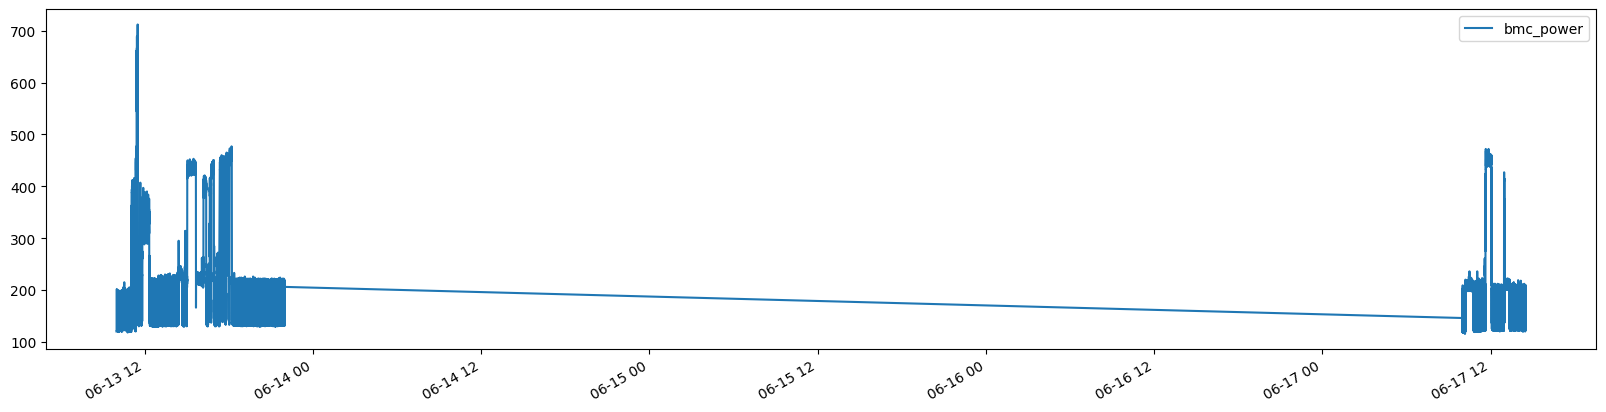

In [497]:
fig, ax = plt.subplots(figsize=(20, 5))
df.plot(y="bmc_power", ax=ax)

In [494]:
def apply_date_format(*axs):
    locator = mdates.HourLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    for ax in axs:
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

    # for ax in axs[1:]:
    #     ax.set_xticklabels([])

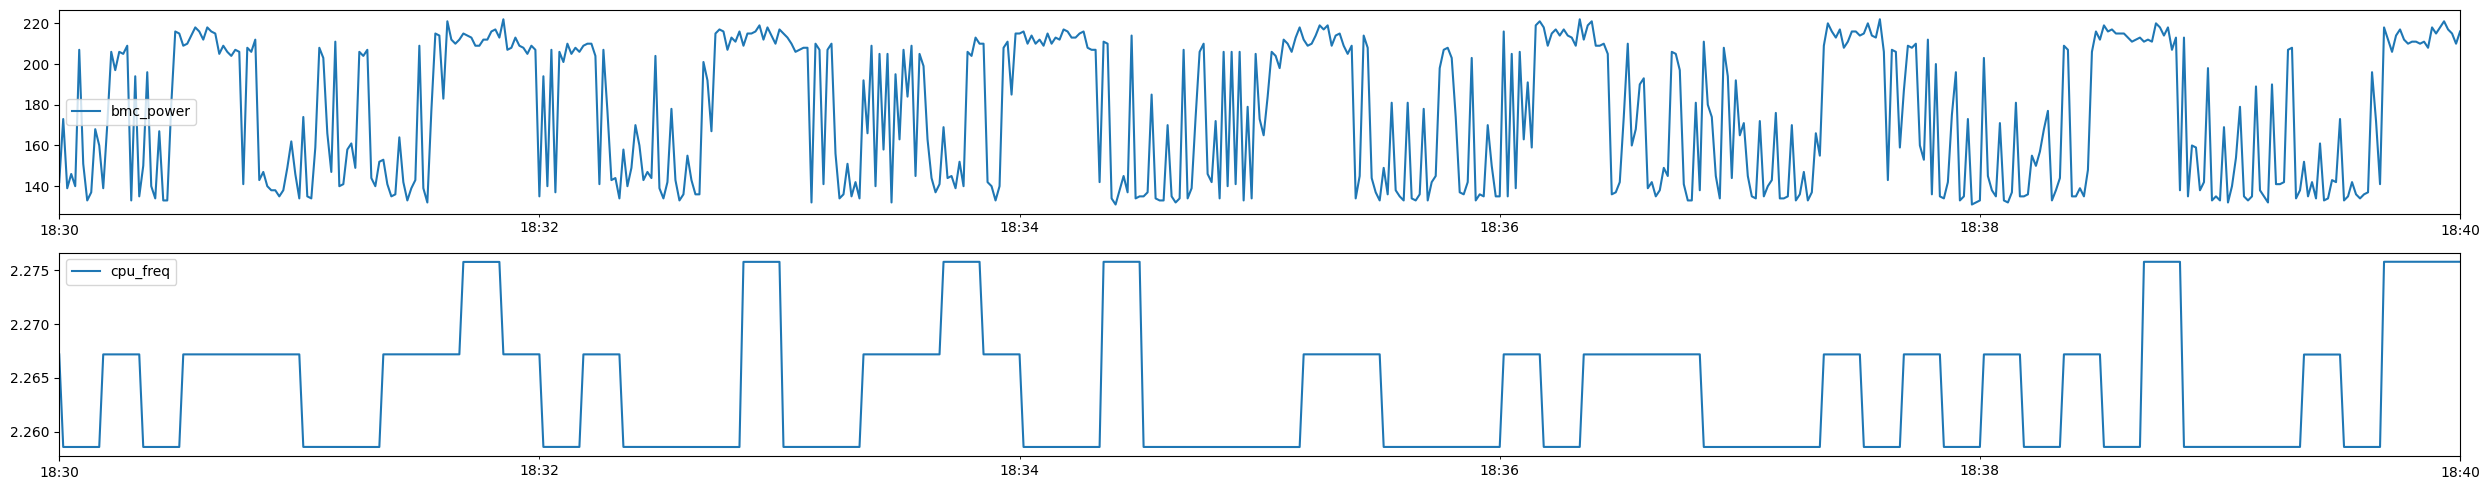

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 5))

idle_start = datetime(year=2025, month=6, day=13, hour=18, minute=30, second=0)
delta = timedelta(minutes=10)
idle_end = idle_start + delta
# idle_end = datetime(year=2025, month=6, day=13, hour=21, minute=50, second=0)

idle_df = df[idle_start:idle_end]

idle_df = idle_df.resample("1s").mean()

idle_df.plot(y="bmc_power", ax=ax1)
idle_df.plot(y="cpu_freq", ax=ax2)

mean_idle = idle_df["bmc_power"].mean()
ax.axhline(mean_idle, color="red", linestyle="--")

ax.set_title(f"Idle power: {mean_idle:.2f} W")

fig.tight_layout()
plt.show()

## Load job information from files

In [499]:
base_dir = Path("/Volumes/pagessin/sync_root/projects/power_c100/outputs")
assert base_dir.exists()

In [500]:
all_runs = list(base_dir.glob("r*"))
all_runs

[PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r001'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r002'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r003'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r004'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r005'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r006'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r007'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r008'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r009'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r010'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r011'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r012'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r013'),
 PosixPath('

In [537]:
# run_df = pd.DataFrame(columns=["run", "start", "end", "duration"])
runs = []
starts = []
log_starts = []
ends = []
log_ends = []
durations = []
events = []
threads = []
procs = []

end_pattern = r"(\d{2}:\d{2}:\d{2}).*Joining Scheduler thread"
start_pattern = r"(\d{2}:\d{2}:\d{2}).*(?:Workers started processing events|AthenaHiveEventLoopMgr.*Starting loop on events)"

base_dt = datetime(year=2025, month=6, day=13, hour=0, minute=0, second=0)

for run in all_runs:
    print(run.name)
    log_file = run / "log.RAWtoALL"
    info_file = run / "info.json"
    assert info_file.exists()
    with info_file.open("r") as f:
        info = json.load(f)
    # print(info)
    runs.append(run.name)
    start_wall = info.get("start_wall", None)
    end_wall = info.get("end_wall", None)
    if start_wall is not None:
        start_wall = datetime.fromisoformat(start_wall)
    if end_wall is not None:
        end_wall = datetime.fromisoformat(end_wall)
    starts.append(start_wall)
    ends.append(end_wall)
    durations.append(info.get("wall_s", None))
    events.append(info.get("events", None))
    threads.append(info.get("threads", None))
    procs.append(info.get("procs", None))

    end_time = None
    start_time = None
    if log_file.exists():
        with open(log_file, "r") as f:
            for line in f:
                end_match = re.search(end_pattern, line)
                start_match = re.search(start_pattern, line)
                if end_match:
                    # print("END: ", end_match.group(0))
                    end_time_str = end_match.group(1)
                    hours, minutes, seconds = map(int, end_time_str.split(":"))
                    end_time = base_dt.replace(
                        hour=hours, minute=minutes, second=seconds
                    )
                if start_match:
                    assert start_time is None, "Multiple start matches"
                    # print("START: ", start_match.group(0))
                    start_time_str = start_match.group(1)
                    hours, minutes, seconds = map(int, start_time_str.split(":"))
                    start_time = base_dt.replace(
                        hour=hours, minute=minutes, second=seconds
                    )
        print("Time from log file: ", start_time, end_time)
        log_starts.append(start_time)
        log_ends.append(end_time)
    else:
        log_starts.append(float("nan"))
        log_ends.append(float("nan"))

    print()

run_df = pd.DataFrame(
    {
        "run": runs,
        "start": starts,
        "end": ends,
        "duration": durations,
        "log_start": log_starts,
        "log_end": log_ends,
        "events": events,
        "threads": threads,
        "procs": procs,
    }
)

run_df = run_df.sort_values(by="run")
run_df = run_df[4:]

r001
Time from log file:  None None

r002
Time from log file:  None None

r003
Time from log file:  2025-06-13 14:25:40 None

r004
Time from log file:  2025-06-13 14:51:19 None

r005
Time from log file:  2025-06-13 14:53:25 2025-06-13 14:56:26

r006
Time from log file:  2025-06-13 15:02:07 2025-06-13 15:39:55

r007
Time from log file:  2025-06-13 16:11:32 2025-06-13 16:23:41

r008
Time from log file:  2025-06-13 16:31:57 2025-06-13 16:37:58

r009
Time from log file:  2025-06-13 16:45:20 2025-06-13 16:56:47

r010
Time from log file:  2025-06-13 17:08:32 2025-06-13 17:14:27

r011
Time from log file:  2025-06-13 17:21:48 2025-06-13 17:32:31

r012
Time from log file:  2025-06-13 17:34:24 2025-06-13 17:45:06

r013
Time from log file:  2025-06-13 17:48:15 2025-06-13 17:59:55

r014
Time from log file:  2025-06-13 18:02:50 2025-06-13 18:13:44

r015
Time from log file:  2025-06-13 10:14:33 2025-06-13 10:44:52

r016

r017



In [538]:
run_df["events"] = run_df["events"].astype(int)
run_df["procs"] = run_df["procs"].astype(int)
run_df["threads"] = run_df["threads"].astype(int)
run_df["cores"] = run_df["threads"] * run_df["procs"]
run_df["log_start"] = pd.to_datetime(run_df["log_start"])
run_df["log_end"] = pd.to_datetime(run_df["log_end"])
run_df["log_duration_s"] = (run_df["log_end"] - run_df["log_start"]).dt.total_seconds()
run_df["throughput_events_s"] = run_df["events"] / run_df["log_duration_s"]
run_df["event_duration_s"] = run_df["log_duration_s"] / run_df["events"]
run_df

,run,start,end,duration,log_start,log_end,events,threads,procs,cores,log_duration_s,throughput_events_s,event_duration_s
4,r005,2025-06-13 14:53:02.886817,2025-06-13 14:57:39.920870,277.034053,2025-06-13 14:53:25,2025-06-13 14:56:26,1000,4,4,16,181.0,5.524862,0.181000
5,r006,2025-06-13 15:01:00.000000,2025-06-13 15:40:00.000000,0,2025-06-13 15:02:07,2025-06-13 15:39:55,50000,4,21,84,2268.0,22.045855,0.045360
6,r007,2025-06-13 16:11:09.961649,2025-06-13 16:24:03.877131,773.915482,2025-06-13 16:11:32,2025-06-13 16:23:41,10000,4,10,40,729.0,13.717421,0.072900
7,r008,2025-06-13 16:31:34.912215,2025-06-13 16:38:08.560737,393.648522,2025-06-13 16:31:57,2025-06-13 16:37:58,500,4,1,4,361.0,1.385042,0.722000
8,r009,2025-06-13 16:44:58.454411,2025-06-13 16:56:52.921619,714.467208,2025-06-13 16:45:20,2025-06-13 16:56:47,15000,4,21,84,687.0,21.834061,0.045800
9,r010,2025-06-13 17:08:10.645844,2025-06-13 17:14:34.344619,383.698775,2025-06-13 17:08:32,2025-06-13 17:14:27,1000,4,2,8,355.0,2.816901,0.355000
10,r011,2025-06-13 17:21:26.602175,2025-06-13 17:32:50.044281,683.442106,2025-06-13 17:21:48,2025-06-13 17:32:31,15000,4,26,104,643.0,23.328149,0.042867
11,r012,2025-06-13 17:34:02.524615,2025-06-13 17:45:24.961763,682.437148,2025-06-13 17:34:24,2025-06-13 17:45:06,15000,4,26,104,642.0,23.364486,0.042800
12,r013,2025-06-13 17:47:52.577174,2025-06-13 18:00:16.709301,744.132127,2025-06-13 17:48:15,2025-06-13 17:59:55,17500,4,32,128,700.0,25.000000,0.040000
13,r014,2025-06-13 18:02:27.374117,2025-06-13 18:14:05.851552,698.477435,2025-06-13 18:02:50,2025-06-13 18:13:44,17500,4,40,160,654.0,26.758410,0.037371


r003
2025-06-13 14:25:41 2025-06-13 14:33:01
47 495 448
1.1487179487179486


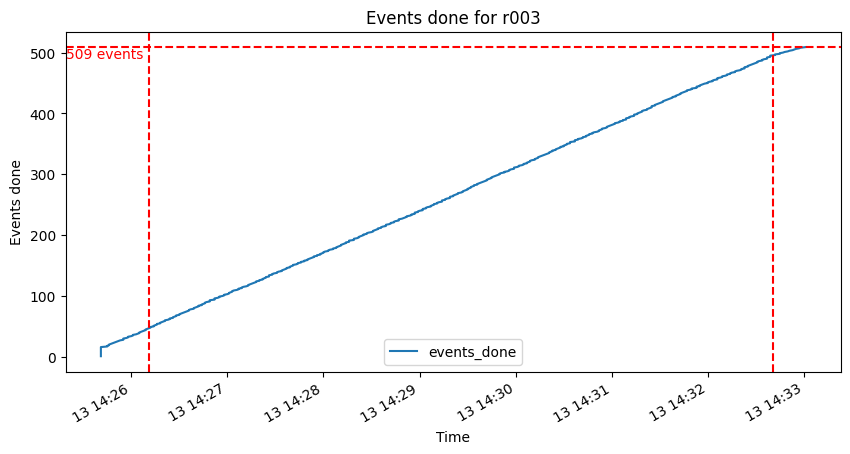

r004
MAIN /Volumes/pagessin/sync_root/projects/power_c100/outputs/r004/log.RAWtoALL
2025-06-13 14:51:19 2025-06-13 14:52:32
38 72 34
1.4782608695652173


/var/folders/25/4_8mtscd76z0dyl6_414z67m0000gn/T/ipykernel_94599/2867952127.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025-06-13 14:26:11' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  run_df.loc[run_df.run == run.name, "slope_start"] = win_start
/var/folders/25/4_8mtscd76z0dyl6_414z67m0000gn/T/ipykernel_94599/2867952127.py:106: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025-06-13 14:32:41' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  run_df.loc[run_df.run == run.name, "slope_end"] = win_end


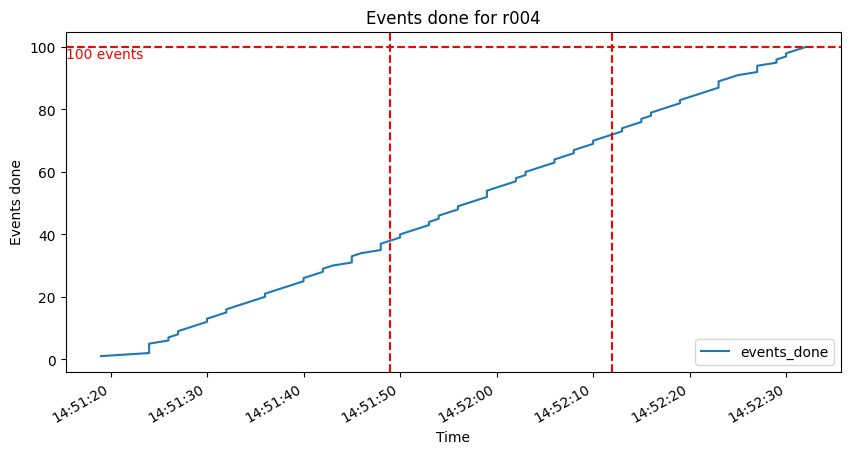

r005
2025-06-13 14:53:26 2025-06-13 14:55:24
167 562 395
5.8088235294117645


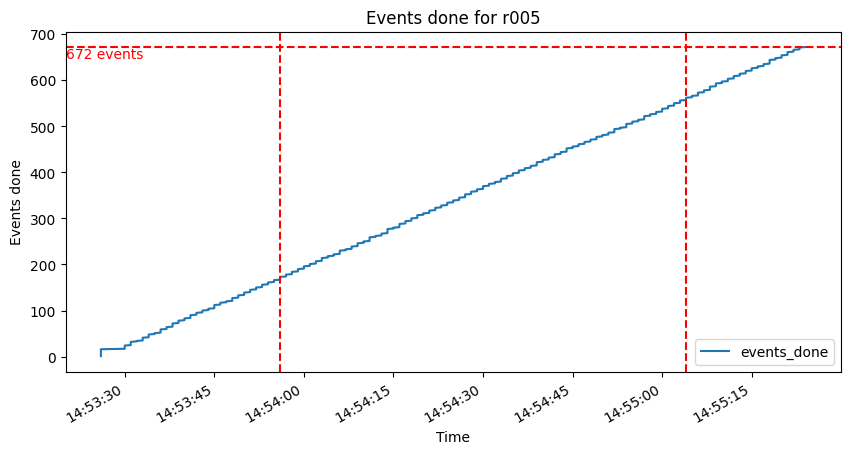

r006
2025-06-13 15:02:09 2025-06-13 15:04:54
656 3218 2562
22.278260869565216


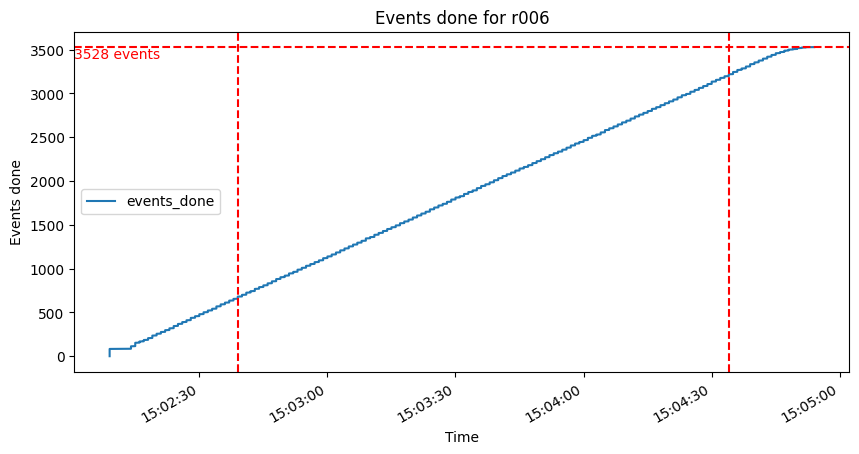

r007
2025-06-13 16:11:33 2025-06-13 16:13:38
408 1455 1047
13.96


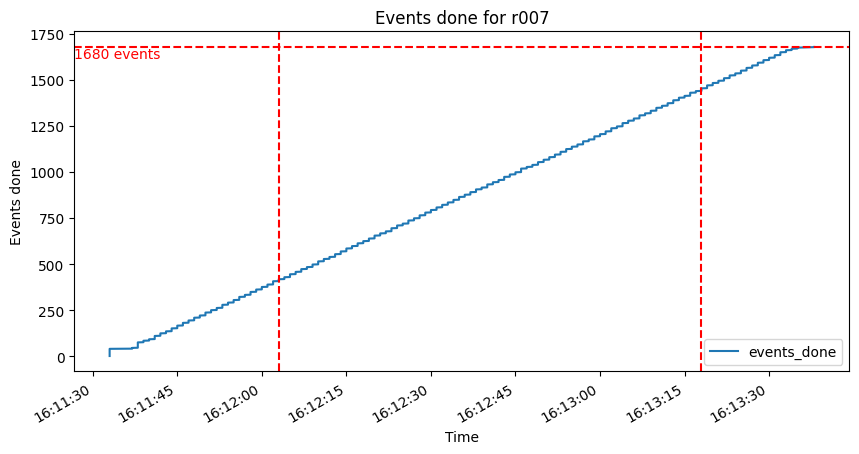

r008
MAIN /Volumes/pagessin/sync_root/projects/power_c100/outputs/r008/log.RAWtoALL
2025-06-13 16:31:57 2025-06-13 16:34:57
38 222 184
1.4153846153846155


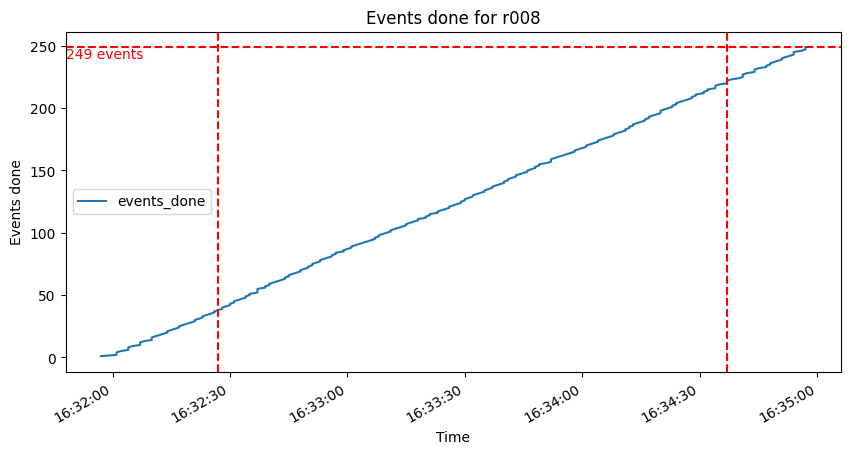

r009
2025-06-13 16:45:22 2025-06-13 16:48:05
669 3207 2538
22.460176991150444


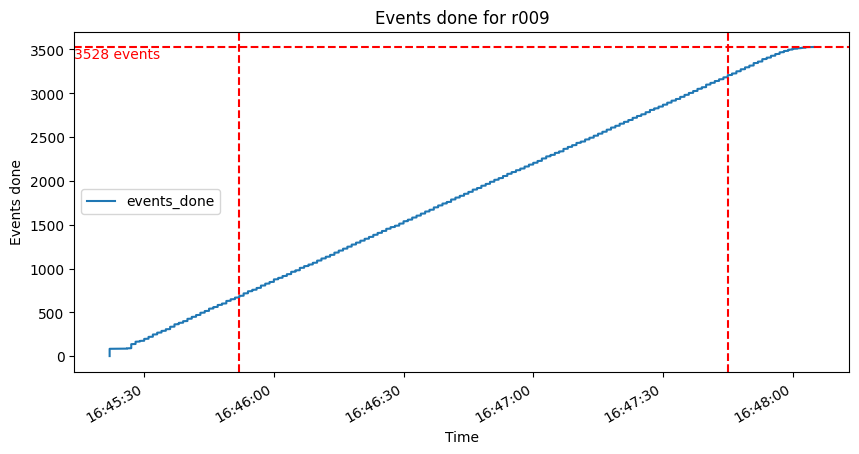

r010
2025-06-13 17:08:33 2025-06-13 17:10:32
85 281 196
2.8405797101449277


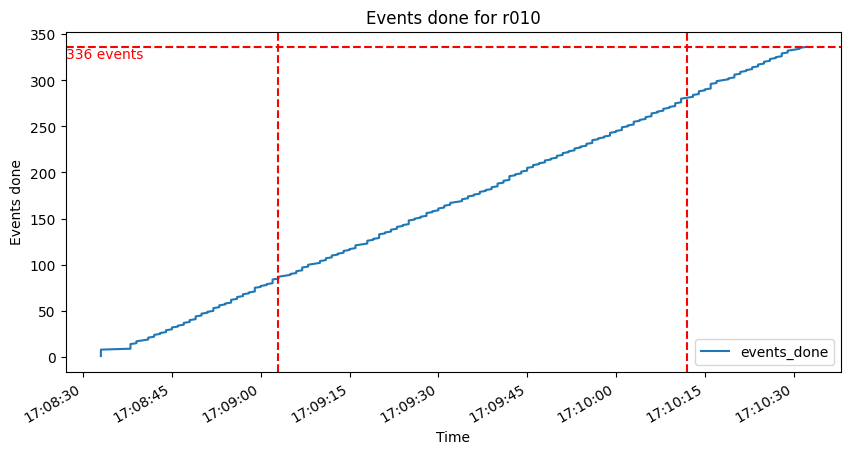

r011
2025-06-13 17:21:50 2025-06-13 17:24:57
726 4030 3304
24.116788321167885


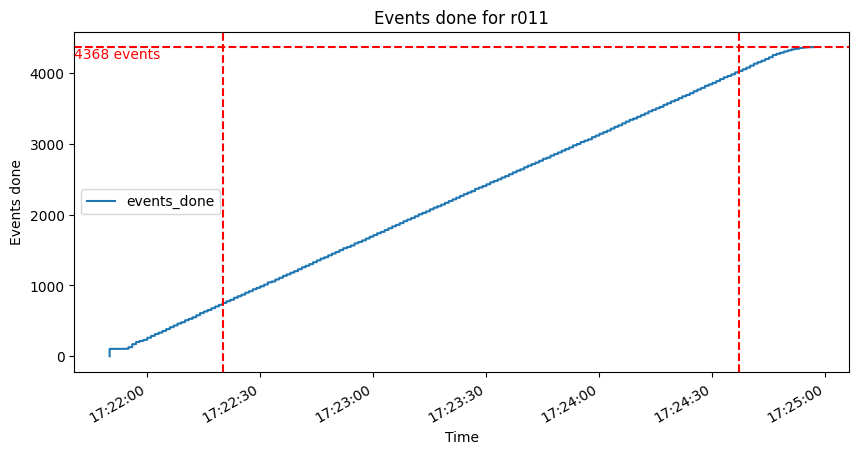

r012
2025-06-13 17:34:26 2025-06-13 17:37:34
723 4065 3342
24.217391304347824


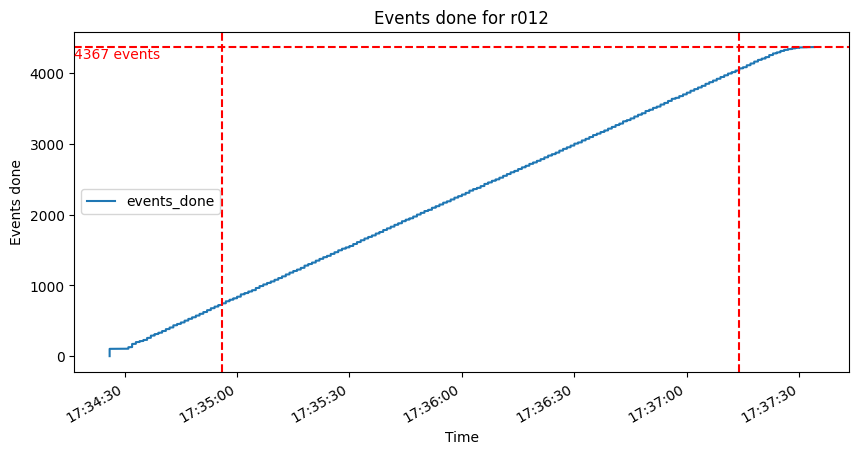

r013
2025-06-13 17:48:16 2025-06-13 17:51:53
782 5100 4318
25.856287425149702


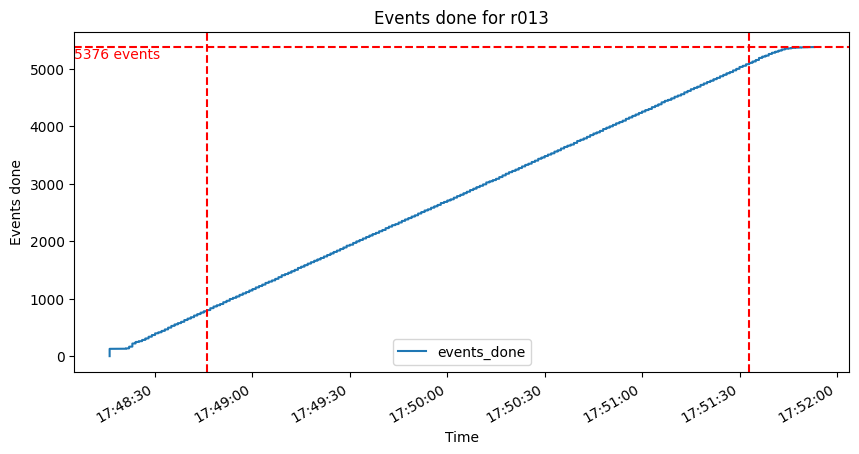

r014
2025-06-13 18:02:51 2025-06-13 18:07:00
842 6400 5558
27.92964824120603


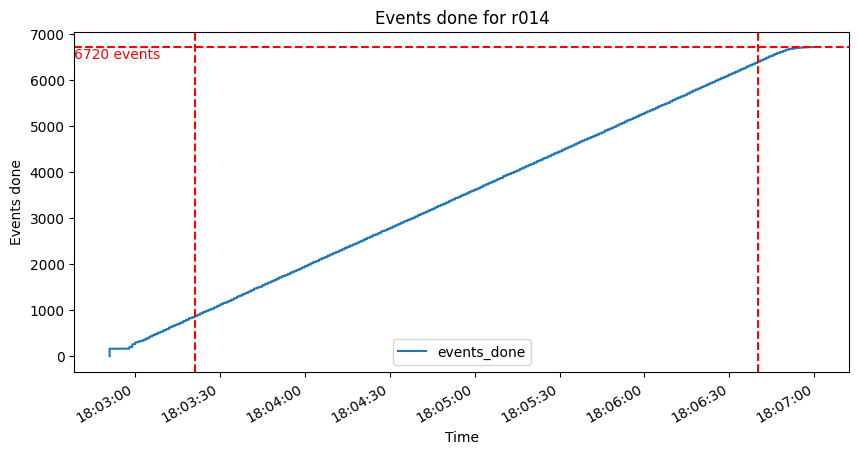

r015
MAIN /Volumes/pagessin/sync_root/projects/power_c100/outputs/r015/log.RAWtoALL
2025-06-17 10:14:33 2025-06-17 10:29:40
9 242 233
0.2718786464410735


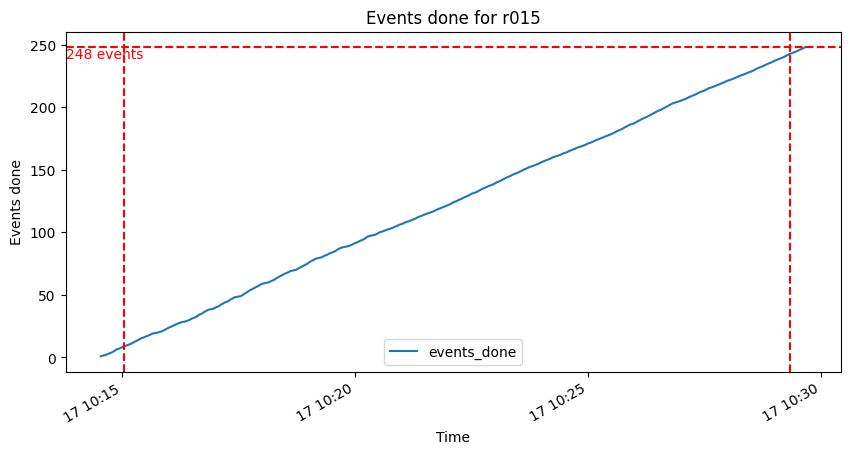

r016
/Volumes/pagessin/sync_root/projects/power_c100/outputs/r016
2025-06-17 11:39:53 2025-06-17 12:04:07
677 39986 39309
27.997863247863247


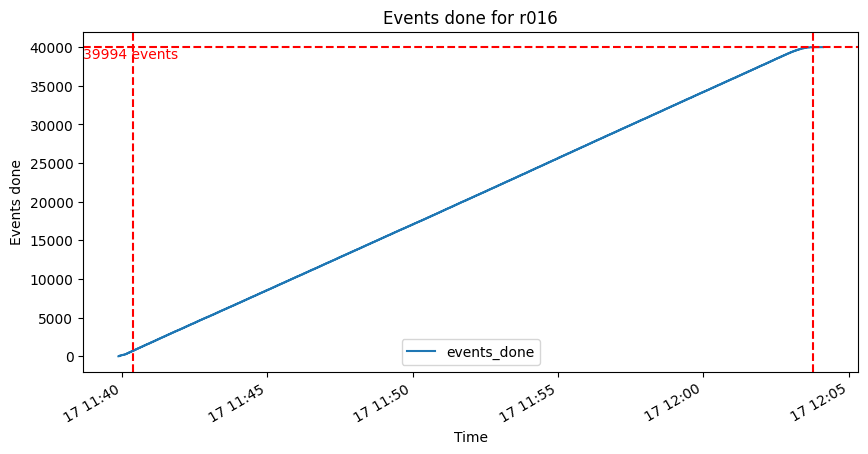

r017
/Volumes/pagessin/sync_root/projects/power_c100/outputs/r017
2025-06-17 12:59:33 2025-06-17 13:10:21
12 240 228
0.38127090301003347


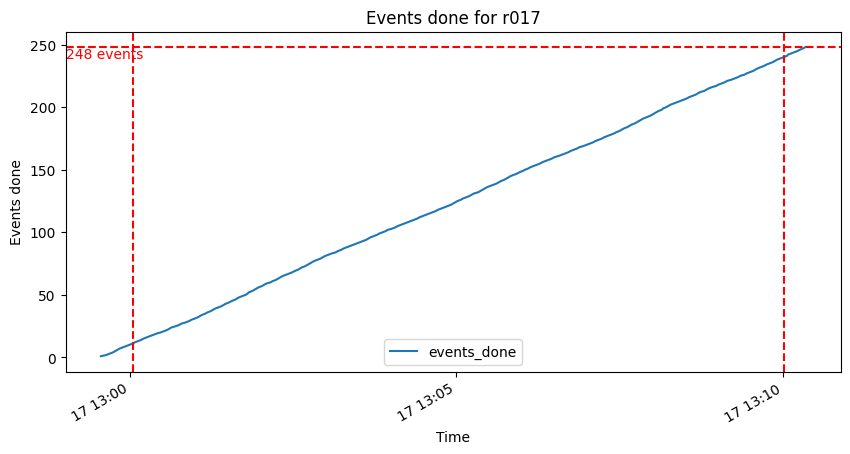

In [539]:
event_pattern = r"^.*(?:\d{4}-\d{2}-\d{2})?(\d{2}:\d{2}:\d{2})(?:,\d+)?.*start processing event #\d+, run #\d+.*"

run_df["throughput_events_slope_s"] = np.zeros_like(run_df["throughput_events_s"])
run_df["slope_start"] = np.zeros_like(run_df["throughput_events_s"])
run_df["slope_end"] = np.zeros_like(run_df["throughput_events_s"])

for run in all_runs[2:]:
    log_file = run / "log.RAWtoALL"
    print(run.name)
    if log_file.exists():
        logs = list(run.glob("athenaMP*/worker_*/AthenaMP.log"))
    else:
        print(run)
        logs = list(run.glob("proc_*/log.RAWtoALL"))

    timestamps = []
    count = []

    day = None

    if len(logs) == 0:
        # parse from main file
        print("MAIN", log_file)
        with log_file.open("r") as f:
            for line in f:
                if day is None:
                    # 16:31:42 Fri Jun 13 16:31:42 CEST 2025
                    # print(line)
                    match = re.match(
                        r"^(\d{2}:\d{2}:\d{2}) (Mon|Tue|Wed|Thu|Fri|Sat|Sun) (Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec) (\d{2}) .* (\d{4})",
                        line,
                    )
                    if match is not None:
                        (
                            time_str,
                            _,
                            month,
                            day,
                            year,
                        ) = match.groups()
                        day = datetime.strptime(f"{day} {month} {year}", "%d %b %Y")

                match = re.match(event_pattern, line)
                if match is not None:
                    (time,) = match.groups()
                    hours, minutes, seconds = map(int, time.split(":"))
                    timestamp = day.replace(hour=hours, minute=minutes, second=seconds)
                    timestamps.append(timestamp)
                    count.append(1)

    else:
        for log in logs:
            with log.open("r") as f:
                for line in f:
                    if day is None:
                        # 16:31:42 Fri Jun 13 16:31:42 CEST 2025
                        # print(line)
                        match = re.match(
                            r"^(\d{2}:\d{2}:\d{2}) (Mon|Tue|Wed|Thu|Fri|Sat|Sun) (Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec) (\d{2}) .* (\d{4})",
                            line,
                        )
                        if match is not None:
                            (
                                time_str,
                                _,
                                month,
                                day,
                                year,
                            ) = match.groups()
                            day = datetime.strptime(f"{day} {month} {year}", "%d %b %Y")
                    match = re.match(event_pattern, line)
                    if match is not None:
                        if day is None:
                            m = re.match(r"^(\d{4})-(\d{2})-(\d{2}).*", line)
                            if m is None:
                                raise ValueError(
                                    "Have no day yet but encountered event"
                                )
                            year, month, day = map(int, m.groups())
                            day = datetime(year=year, month=month, day=day)
                        (time,) = match.groups()
                        hours, minutes, seconds = map(int, time.split(":"))
                        timestamp = day.replace(
                            hour=hours, minute=minutes, second=seconds
                        )
                        # print(timestamp)
                        timestamps.append(timestamp)
                        count.append(1)
                        # print(match.group(0))
    events_df = pd.DataFrame(
        data={"timestamp": pd.to_datetime(timestamps), "count": count}
    )
    events_df = events_df.sort_values(by="timestamp")
    events_df["events_done"] = events_df["count"].cumsum()
    events_df.index = events_df["timestamp"]

    fig, ax = plt.subplots(figsize=(10, 5))
    events_df.plot(y="events_done", ax=ax)
    ax.axhline(events_df.iloc[-1]["events_done"], color="red", linestyle="--")
    ax.text(
        0,
        events_df.iloc[-1]["events_done"],
        f"{events_df.iloc[-1]['events_done']} events",
        color="red",
        ha="left",
        va="top",
        transform=ax.get_yaxis_transform(),
    )
    ax.set_ylabel("Events done")
    ax.set_xlabel("Time")
    ax.set_title(f"Events done for {run.name}")

    win_start = events_df.index[0] + timedelta(seconds=30)
    win_end = events_df.index[-1] - timedelta(seconds=20)

    log_start = events_df.index[0]
    log_end = events_df.index[-1]

    print(log_start, log_end)

    win_width = (win_end - win_start).total_seconds()
    events_start = events_df[win_start:win_end].iloc[0]["events_done"]
    events_end = events_df[win_start:win_end].iloc[-1]["events_done"]

    print(events_start, events_end, events_end - events_start)

    throughput = (events_end - events_start) / win_width
    print(throughput)

    ax.axvline(win_start, color="red", linestyle="--")
    ax.axvline(win_end, color="red", linestyle="--")

    plt.show()

    run_df.loc[run_df.run == run.name, "throughput_events_slope_s"] = throughput
    run_df.loc[run_df.run == run.name, "slope_start"] = win_start
    run_df.loc[run_df.run == run.name, "slope_end"] = win_end


In [540]:
run_df

,run,start,end,duration,log_start,log_end,events,threads,procs,cores,log_duration_s,throughput_events_s,event_duration_s,throughput_events_slope_s,slope_start,slope_end
4,r005,2025-06-13 14:53:02.886817,2025-06-13 14:57:39.920870,277.034053,2025-06-13 14:53:25,2025-06-13 14:56:26,1000,4,4,16,181.0,5.524862,0.181000,5.808824,2025-06-13 14:53:56,2025-06-13 14:55:04
5,r006,2025-06-13 15:01:00.000000,2025-06-13 15:40:00.000000,0,2025-06-13 15:02:07,2025-06-13 15:39:55,50000,4,21,84,2268.0,22.045855,0.045360,22.278261,2025-06-13 15:02:39,2025-06-13 15:04:34
6,r007,2025-06-13 16:11:09.961649,2025-06-13 16:24:03.877131,773.915482,2025-06-13 16:11:32,2025-06-13 16:23:41,10000,4,10,40,729.0,13.717421,0.072900,13.960000,2025-06-13 16:12:03,2025-06-13 16:13:18
7,r008,2025-06-13 16:31:34.912215,2025-06-13 16:38:08.560737,393.648522,2025-06-13 16:31:57,2025-06-13 16:37:58,500,4,1,4,361.0,1.385042,0.722000,1.415385,2025-06-13 16:32:27,2025-06-13 16:34:37
8,r009,2025-06-13 16:44:58.454411,2025-06-13 16:56:52.921619,714.467208,2025-06-13 16:45:20,2025-06-13 16:56:47,15000,4,21,84,687.0,21.834061,0.045800,22.460177,2025-06-13 16:45:52,2025-06-13 16:47:45
9,r010,2025-06-13 17:08:10.645844,2025-06-13 17:14:34.344619,383.698775,2025-06-13 17:08:32,2025-06-13 17:14:27,1000,4,2,8,355.0,2.816901,0.355000,2.840580,2025-06-13 17:09:03,2025-06-13 17:10:12
10,r011,2025-06-13 17:21:26.602175,2025-06-13 17:32:50.044281,683.442106,2025-06-13 17:21:48,2025-06-13 17:32:31,15000,4,26,104,643.0,23.328149,0.042867,24.116788,2025-06-13 17:22:20,2025-06-13 17:24:37
11,r012,2025-06-13 17:34:02.524615,2025-06-13 17:45:24.961763,682.437148,2025-06-13 17:34:24,2025-06-13 17:45:06,15000,4,26,104,642.0,23.364486,0.042800,24.217391,2025-06-13 17:34:56,2025-06-13 17:37:14
12,r013,2025-06-13 17:47:52.577174,2025-06-13 18:00:16.709301,744.132127,2025-06-13 17:48:15,2025-06-13 17:59:55,17500,4,32,128,700.0,25.000000,0.040000,25.856287,2025-06-13 17:48:46,2025-06-13 17:51:33
13,r014,2025-06-13 18:02:27.374117,2025-06-13 18:14:05.851552,698.477435,2025-06-13 18:02:50,2025-06-13 18:13:44,17500,4,40,160,654.0,26.758410,0.037371,27.929648,2025-06-13 18:03:21,2025-06-13 18:06:40


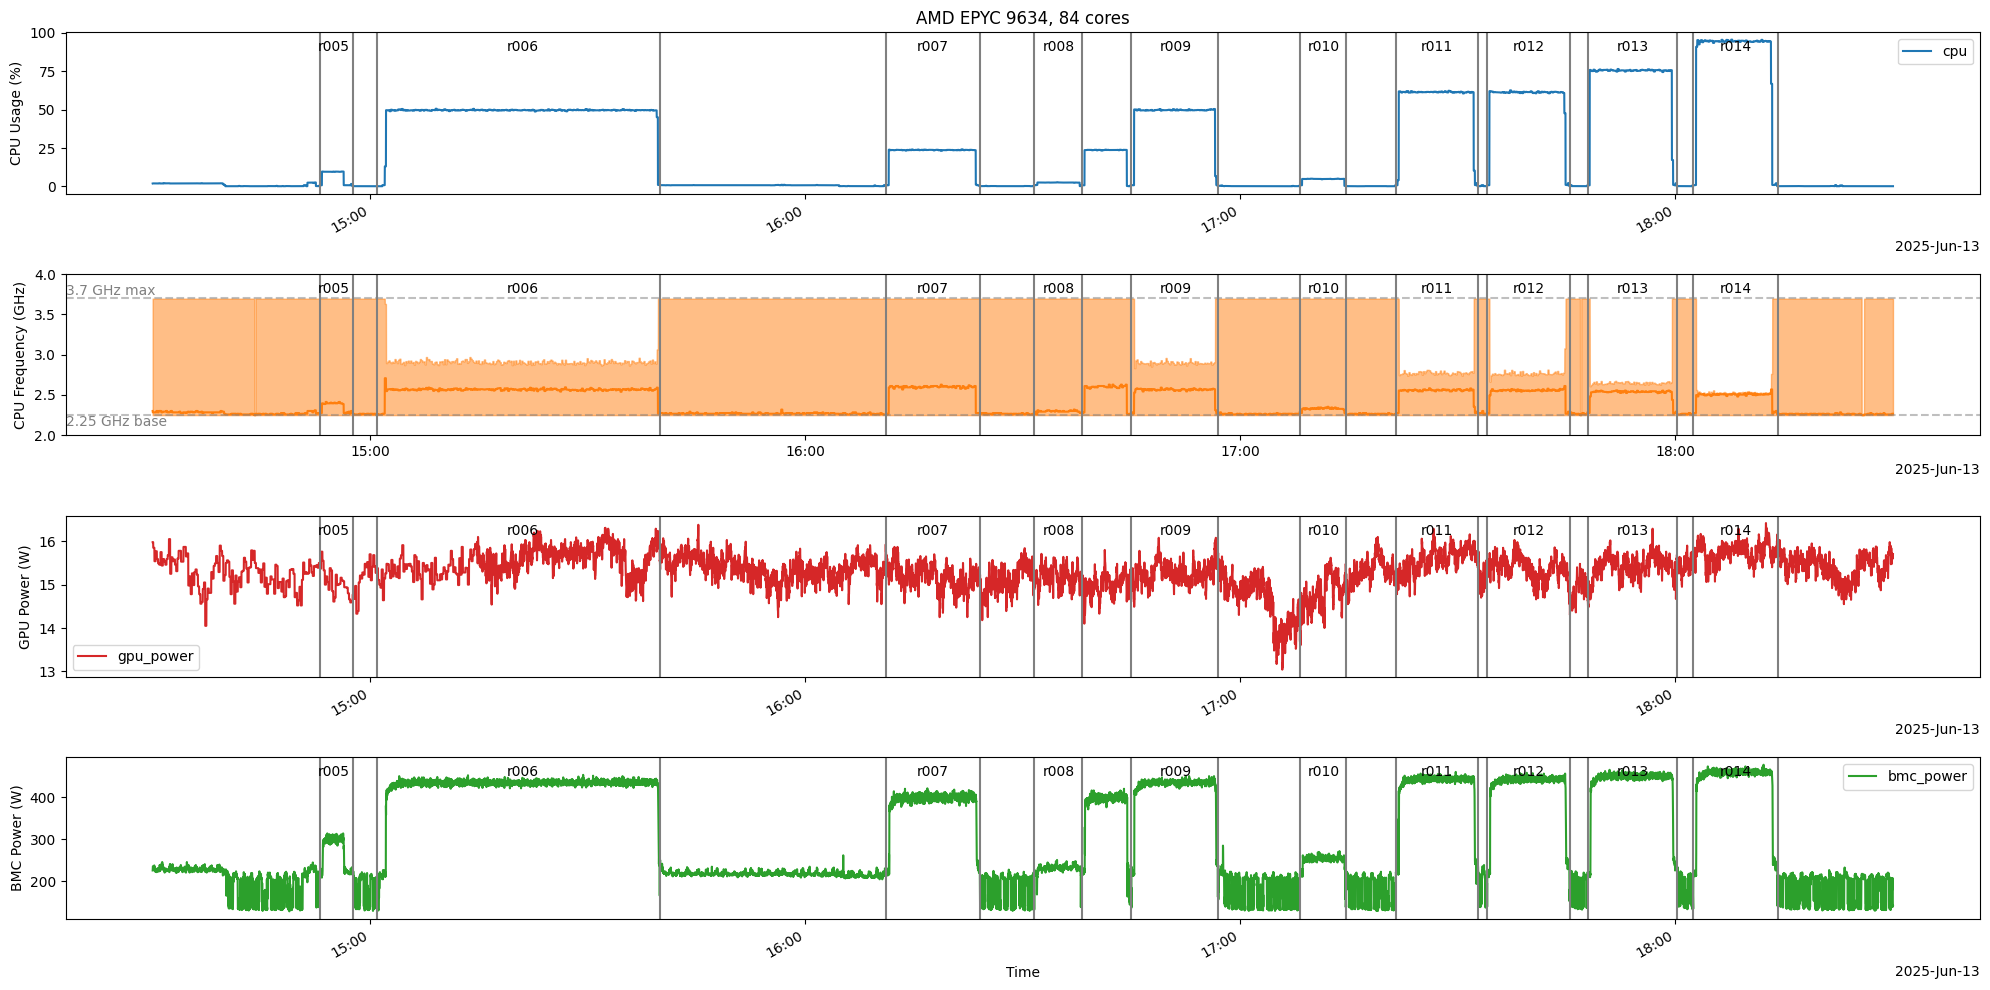

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))

start_date = datetime(2025, 6, 13, 14, 30, 0)
end_date = datetime(2025, 6, 13, 18, 30, 0)
pdf = df[start_date:end_date]

pdf.plot(y="cpu", ax=ax1)
pdf.plot(y="gpu_power", ax=ax3, color="tab:red")
pdf.plot(y="bmc_power", ax=ax4, color="tab:green")

# df.plot(y="cpu_freq", ax=ax2, color="tab:orange", label="CPU Frequency (GHz)")
ax2.fill_between(
    pdf.index, pdf["cpu_freq_max"], pdf["cpu_freq_min"], color="tab:orange", alpha=0.5
)
ax2.plot(pdf.index, pdf["cpu_freq"], color="tab:orange")
ax2.set_ylim(2.0, 4.0)

locator = mdates.HourLocator()

formatter = mdates.ConciseDateFormatter(locator)

apply_date_format(ax1, ax2, ax3, ax4)


ax1.set_ylabel("CPU Usage (%)")
ax2.set_ylabel("CPU Frequency (GHz)")
ax3.set_ylabel("GPU Power (W)")
ax4.set_ylabel("BMC Power (W)")

ax4.set_xlabel("Time")

# ax2.axhline()

ax1.set_title("AMD EPYC 9634, 84 cores")

ax2.axhline(3.7, color="gray", linestyle="--", alpha=0.5)
ax2.axhline(2.25, color="gray", linestyle="--", alpha=0.5)
ax2.text(
    0,
    2.25,
    "2.25 GHz base",
    color="gray",
    ha="left",
    va="top",
    transform=ax2.get_yaxis_transform(),
)
ax2.text(
    0,
    3.7,
    "3.7 GHz max",
    color="gray",
    ha="left",
    va="bottom",
    transform=ax2.get_yaxis_transform(),
)

for run in run_df.itertuples():
    if run.start < start_date or run.end > end_date:
        continue
    pos = run.log_start + (run.log_end - run.log_start) / 2
    for ax in (ax1, ax2, ax3, ax4):
        ymin, ymax = ax.get_ylim()
        ypos = ymax - (ymax - ymin) * 0.05
        ax.axvline(run.start, color="gray")
        ax.axvline(run.end, color="gray")
        ax.text(pos, ypos, run.run, va="top", ha="center")

fig.tight_layout()
fig.savefig("power.pdf")
plt.show()

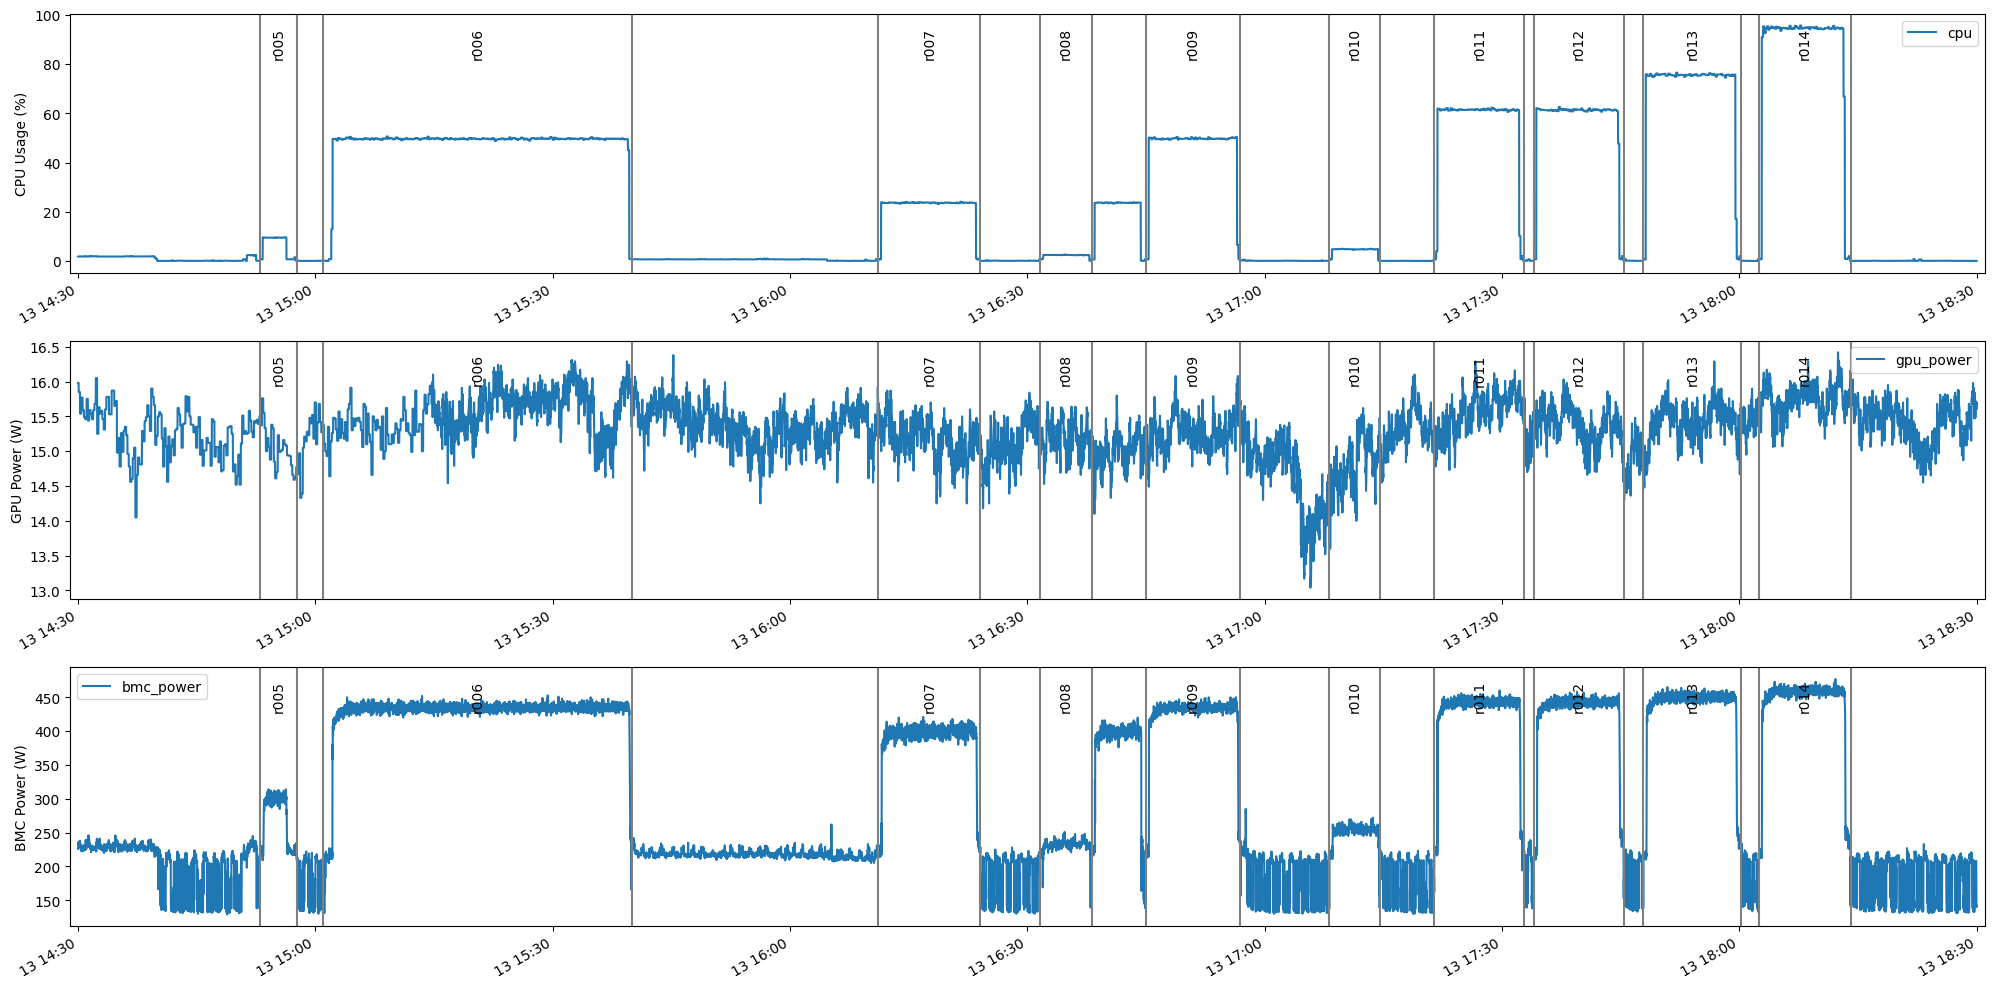

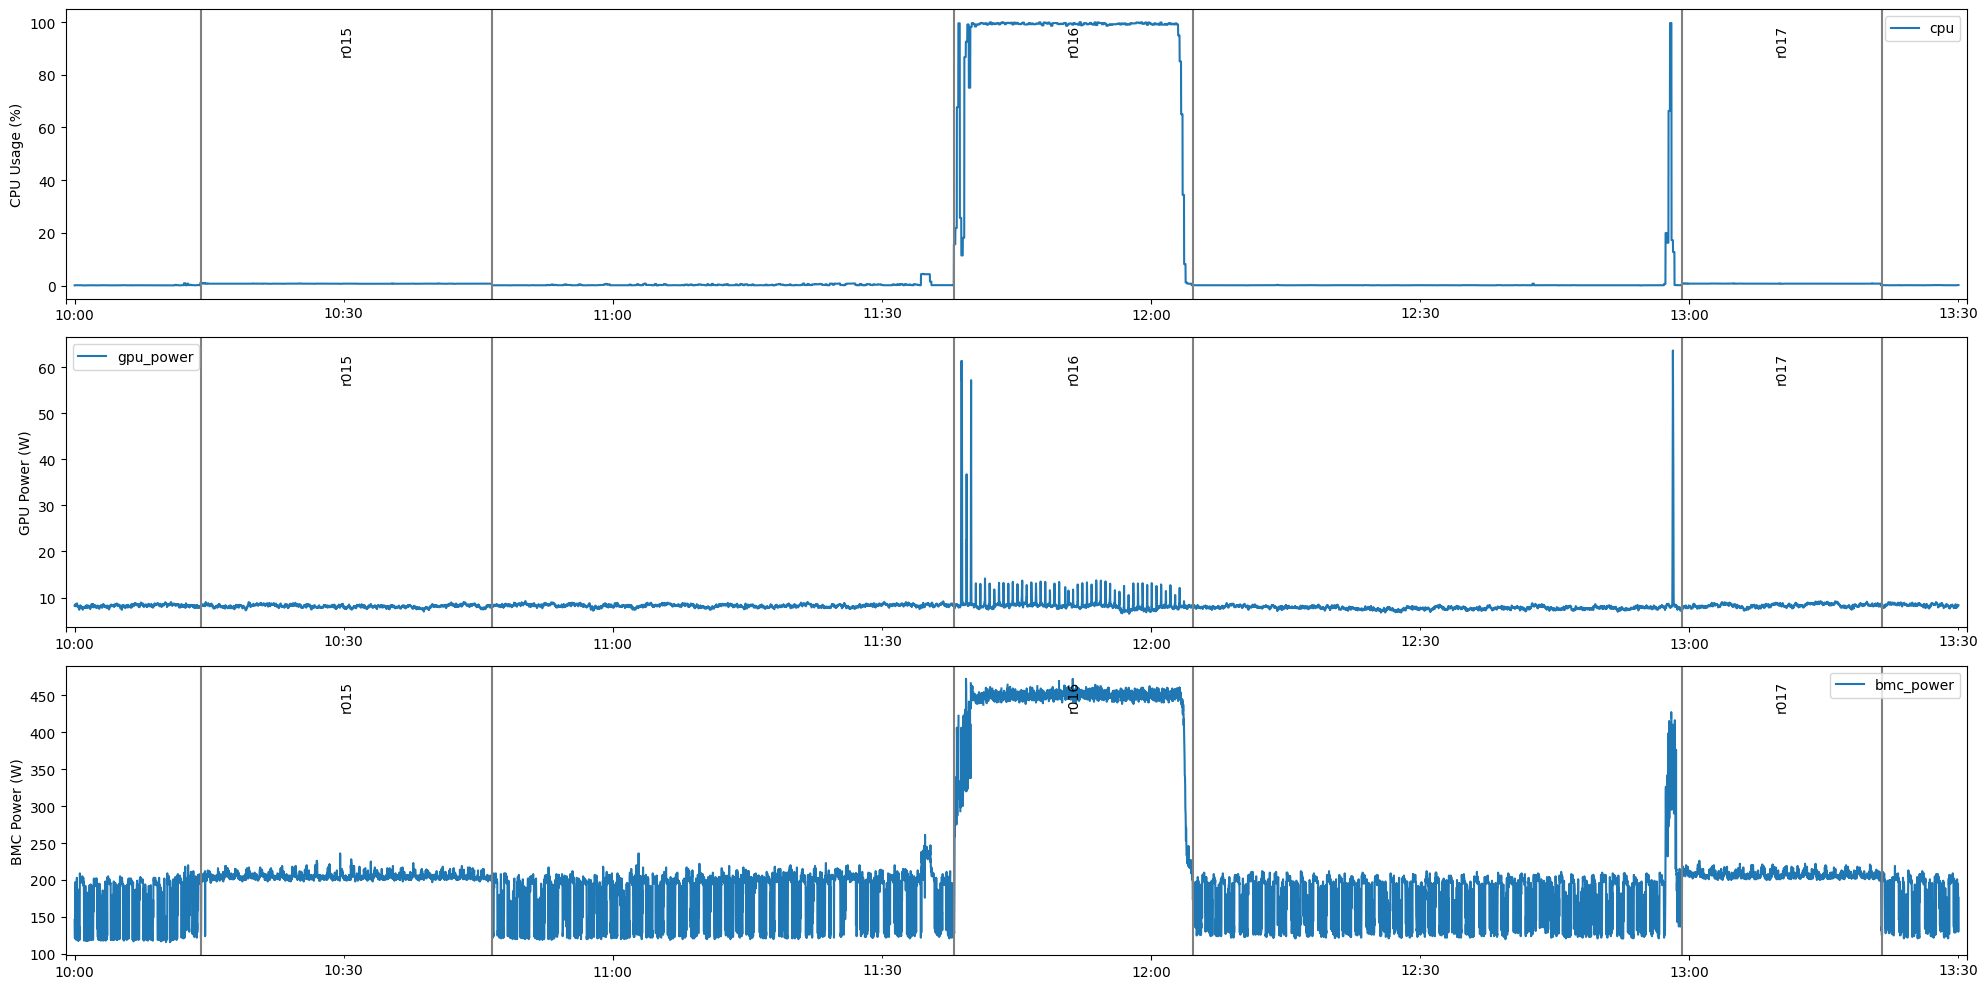

In [561]:
windows = [
    (datetime(2025, 6, 13, 14, 30, 0), datetime(2025, 6, 13, 18, 30, 0)),
    (datetime(2025, 6, 17, 10, 0, 0), datetime(2025, 6, 17, 13, 30, 0)),
]

for start, end in windows:
    wdf = df[start:end]
    # print(wdf)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))
    wdf.plot(y="cpu", ax=ax1)
    wdf.plot(y="gpu_power", ax=ax2)
    wdf.plot(y="bmc_power", ax=ax3)

    # apply_date_format(ax1, ax2, ax3)

    ax1.set_ylabel("CPU Usage (%)")
    ax2.set_ylabel("GPU Power (W)")
    ax3.set_ylabel("BMC Power (W)")

    time_padding = pd.Timedelta(seconds=60)
    for ax in (ax1, ax2, ax3):
        ax.set_xlim(start - time_padding, end + time_padding)

    for run in run_df.itertuples():
        if run.start < start or run.end > end:
            continue
        pos = run.start + (run.end - run.start) / 2
        for ax in (ax1, ax2, ax3):
            ymin, ymax = ax.get_ylim()
            ypos = ymax - (ymax - ymin) * 0.05
            ax.axvline(run.start, color="gray")
            ax.axvline(run.end, color="gray")
            ax.text(pos, ypos, run.run, va="top", ha="center", rotation=90)

    fig.tight_layout()
    fig.savefig("power_with_runs.pdf")
    plt.show()

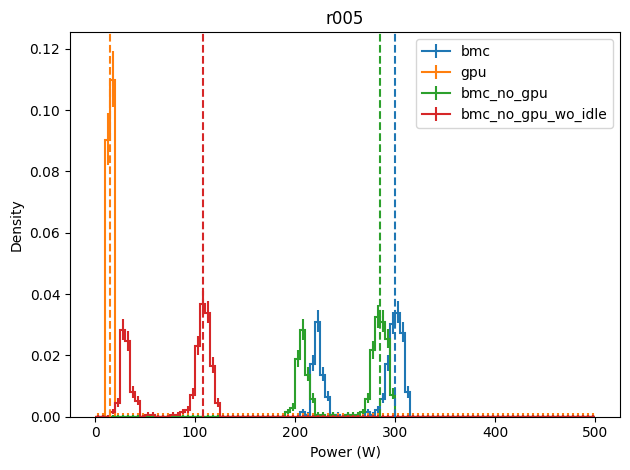

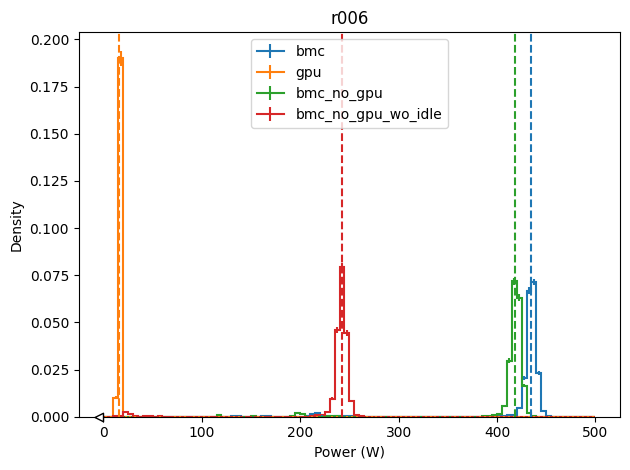

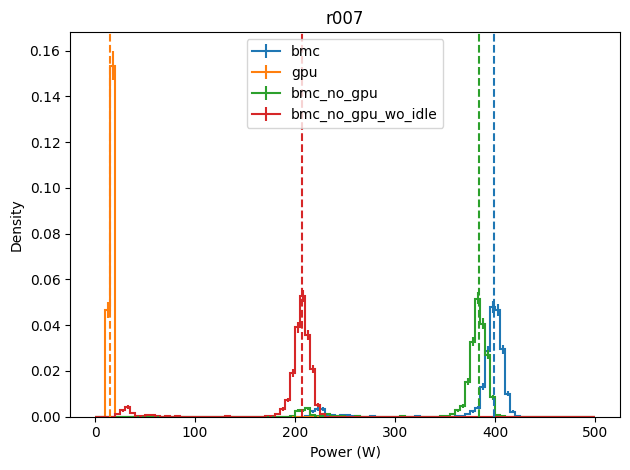

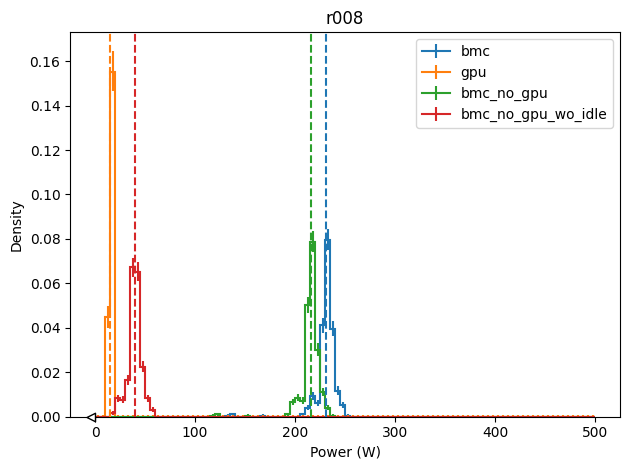

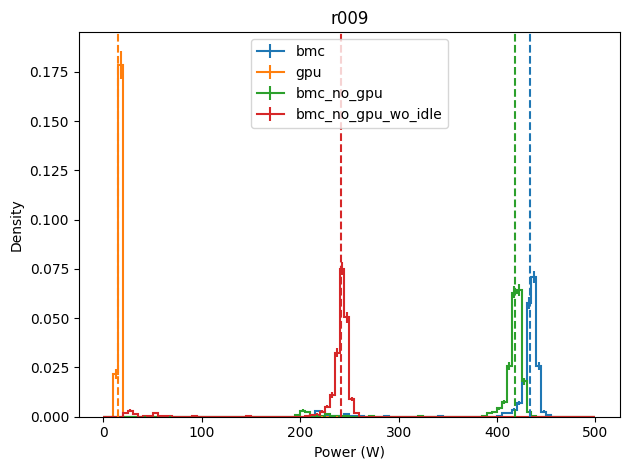

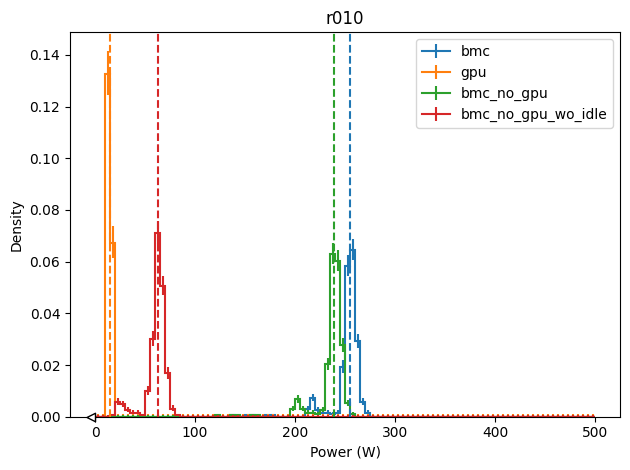

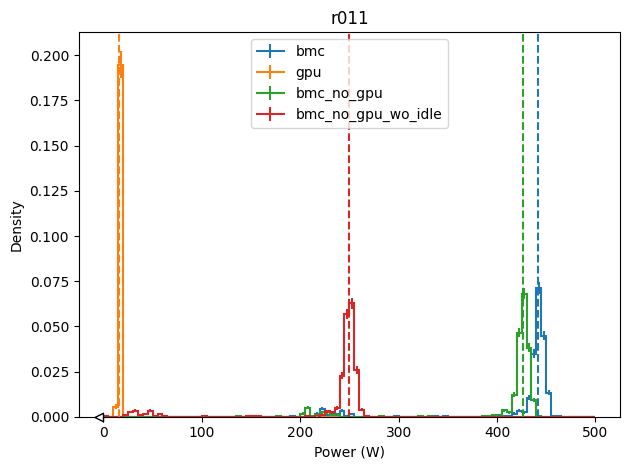

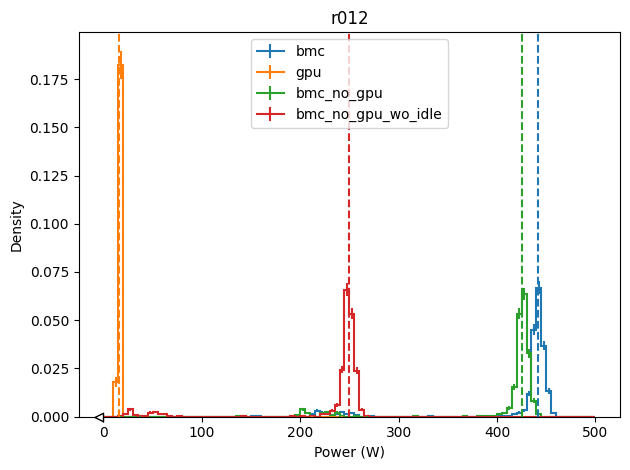

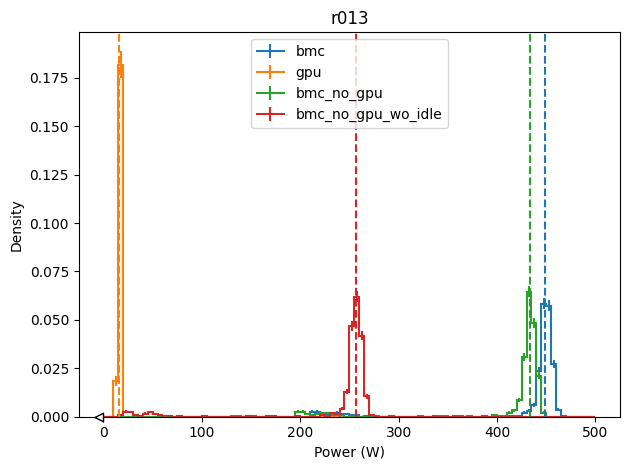

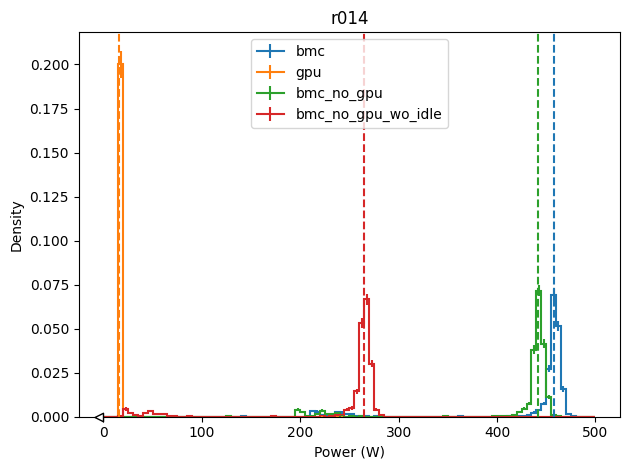

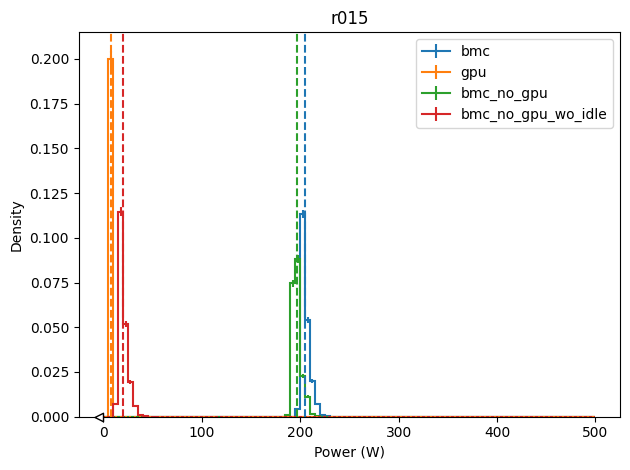

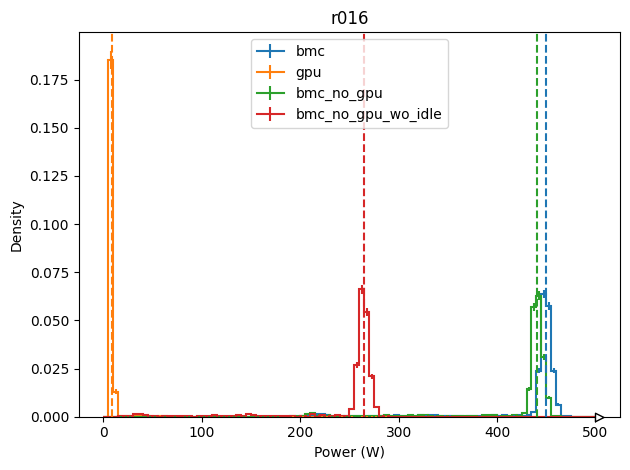

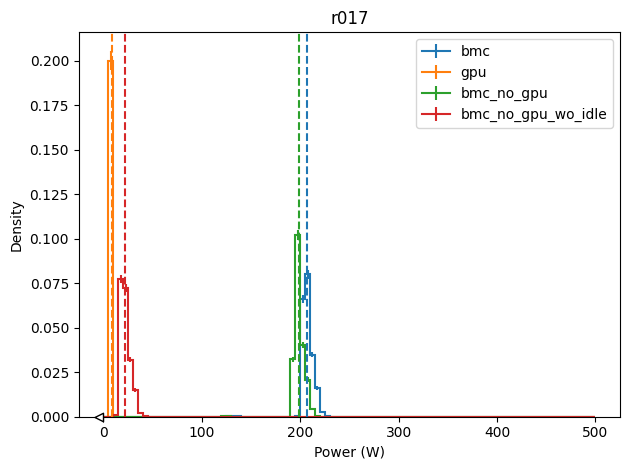

In [641]:
names = []
bmc_power_medians = []
gpu_power_medians = []
bmc_no_gpu_medians = []
bmc_no_gpu_wo_idle_medians = []

def find_peak(values):
    # mode = scipy.stats.mode(values)
    # print(mode)
    h, edges = np.histogram(values, bins=100, range=(0, 500))
    peak = edges[h.argmax()]


    window = values[np.abs(values - peak) < 30]
    return window.mean()


for run in run_df.itertuples():
    # if run.run != "r015": continue
    meas_df = df[run.start : run.end]
    names.append(run.run)
    bmc_power_median = find_peak(meas_df["bmc_power"])
    gpu_power_median = find_peak(meas_df["gpu_power"])
    bmc_power_medians.append(bmc_power_median)
    gpu_power_medians.append(gpu_power_median)

    h = hist.Hist(
        hist.axis.Regular(100, 0, 500, name="power"),
        hist.axis.StrCategory(
            ["bmc", "gpu", "bmc_no_gpu", "bmc_no_gpu_wo_idle"], name="source"
        ),
    )

    bmc = meas_df["bmc_power"]
    bmc_wo_idle = bmc - mean_idle
    bmc_no_gpu = bmc - meas_df["gpu_power"]
    bmc_no_gpu_wo_idle = bmc_no_gpu - mean_idle

    bmc_no_gpu_median = find_peak(bmc_no_gpu)
    bmc_no_gpu_wo_idle_median = find_peak(bmc_no_gpu_wo_idle)
    bmc_no_gpu_medians.append(bmc_no_gpu_median)
    bmc_no_gpu_wo_idle_medians.append(bmc_no_gpu_wo_idle_median)

    h.fill(bmc, source="bmc")
    h.fill(bmc_wo_idle, source="bmc_wo_idle")
    h.fill(bmc_no_gpu, source="bmc_no_gpu")
    h.fill(bmc_no_gpu_wo_idle, source="bmc_no_gpu_wo_idle")

    h.fill(meas_df["bmc_power"], source="bmc")
    h.fill(meas_df["gpu_power"], source="gpu")
    h.fill(bmc_no_gpu, source="bmc_no_gpu")
    h.fill(bmc_no_gpu - mean_idle, source="bmc_no_gpu_wo_idle")

    fig, ax = plt.subplots()
    h.plot(ax=ax, density=True)
    ax.axvline(bmc_power_median, color="tab:blue", linestyle="--")
    ax.axvline(gpu_power_median, color="tab:orange", linestyle="--")
    ax.axvline(bmc_no_gpu_median, color="tab:green", linestyle="--")
    ax.axvline(bmc_no_gpu_wo_idle_median, color="tab:red", linestyle="--")

    ax.set_xlabel("Power (W)")
    ax.set_ylabel("Density")
    ax.set_title(run.run)
    ax.legend()
    fig.tight_layout()
    outdir = Path.cwd() / "power_dist"
    outdir.mkdir(exist_ok=True)
    fig.savefig(outdir / f"power_{run.run}.pdf")
    plt.show()

    # break


run_df["bmc_power"] = bmc_power_medians
run_df["gpu_power"] = gpu_power_medians
run_df["bmc_no_gpu"] = bmc_no_gpu_medians
run_df["bmc_no_gpu_wo_idle"] = bmc_no_gpu_wo_idle_medians

# run_df.to_csv("power_dist.csv")

In [653]:
run_df["j_per_ev_bmc_no_gpu"] = (
    run_df["bmc_no_gpu"] / run_df["throughput_events_slope_s"]
)

run_df["j_per_ev_bmc_no_gpu_wo_idle"] = (
    run_df["bmc_no_gpu_wo_idle"] / run_df["throughput_events_slope_s"]
)

run_df[
    [
        "run",
        "events",
        "throughput_events_slope_s",
        "throughput_events_s",
        "bmc_no_gpu",
        "j_per_ev_bmc_no_gpu",
        "bmc_no_gpu_wo_idle",
        "j_per_ev_bmc_no_gpu_wo_idle",
    ]
]

,run,events,throughput_events_slope_s,throughput_events_s,bmc_no_gpu,j_per_ev_bmc_no_gpu,bmc_no_gpu_wo_idle,j_per_ev_bmc_no_gpu_wo_idle
4,r005,1000,5.808824,5.524862,285.024057,49.067433,108.150848,18.618374
5,r006,50000,22.278261,22.045855,418.770343,18.797264,242.082545,10.866313
6,r007,10000,13.960000,13.717421,383.464014,27.468769,206.807475,14.814289
7,r008,500,1.415385,1.385042,216.206154,152.754348,39.503991,27.910428
8,r009,15000,22.460177,21.834061,418.637733,18.639111,241.935570,10.771757
9,r010,1000,2.840580,2.816901,239.440500,84.292829,62.928451,22.153383
10,r011,15000,24.116788,23.328149,426.139040,17.669809,249.485754,10.344900
11,r012,15000,24.217391,23.364486,425.845040,17.584266,249.142877,10.287767
12,r013,17500,25.856287,25.000000,433.302733,16.758119,256.600570,9.924107
13,r014,17500,27.929648,26.758410,441.859713,15.820454,265.206306,9.495512


In [650]:
plot_df = (
    run_df[
        run_df.run.isin(
            [
                "r005",
                "r006",
                "r007",
                "r008",
                "r009",
                "r010",
                "r011",
                "r012",
                "r013",
                "r014",
                "r016",
                "r017",
            ]
        )
    ]
    .sort_values(by="cores")
    .sort_values(by="cores")
)
plot_df

,run,start,end,duration,log_start,log_end,events,threads,procs,cores,...,bmc_no_gpu_mean,bmc_no_gpu_std,bmc_no_gpu_wo_idle_mean,bmc_no_gpu_wo_idle_std,j_per_ev_bmc_no_gpu,j_per_ev_bmc_no_gpu_wo_idle,bmc_power,gpu_power,bmc_no_gpu,bmc_no_gpu_wo_idle
16,r017,2025-06-17 12:59:10.127554,2025-06-17 13:21:26.548652,1336.421098,NaT,NaT,500,1,1,1,...,NaN,NaN,NaN,NaN,521.916677,58.461004,207.274569,8.282395,198.991643,22.289480
7,r008,2025-06-13 16:31:34.912215,2025-06-13 16:38:08.560737,393.648522,2025-06-13 16:31:57,2025-06-13 16:37:58,500,4,1,4,...,217.118702,6.604627,40.416539,6.604627,152.754348,27.910428,231.379487,15.171853,216.206154,39.503991
9,r010,2025-06-13 17:08:10.645844,2025-06-13 17:14:34.344619,383.698775,2025-06-13 17:08:32,2025-06-13 17:14:27,1000,4,2,8,...,239.730112,7.013049,63.027949,7.013049,84.292829,22.153383,254.898017,14.803932,239.440500,62.928451
4,r005,2025-06-13 14:53:02.886817,2025-06-13 14:57:39.920870,277.034053,2025-06-13 14:53:25,2025-06-13 14:56:26,1000,4,4,16,...,282.607253,14.300798,105.905090,14.300798,49.067433,18.618374,300.097143,15.038087,285.024057,108.150848
6,r007,2025-06-13 16:11:09.961649,2025-06-13 16:24:03.877131,773.915482,2025-06-13 16:11:32,2025-06-13 16:23:41,10000,4,10,40,...,381.658247,17.882280,204.956084,17.882280,27.468769,14.814289,398.630556,15.173230,383.464014,206.807475
5,r006,2025-06-13 15:01:00.000000,2025-06-13 15:40:00.000000,0,2025-06-13 15:02:07,2025-06-13 15:39:55,50000,4,21,84,...,417.550680,15.546634,240.848517,15.546634,18.797264,10.866313,434.363515,15.524747,418.770343,242.082545
8,r009,2025-06-13 16:44:58.454411,2025-06-13 16:56:52.921619,714.467208,2025-06-13 16:45:20,2025-06-13 16:56:47,15000,4,21,84,...,415.414797,25.067829,238.712633,25.067829,18.639111,10.771757,433.918519,15.279230,418.637733,241.935570
10,r011,2025-06-13 17:21:26.602175,2025-06-13 17:32:50.044281,683.442106,2025-06-13 17:21:48,2025-06-13 17:32:31,15000,4,26,104,...,421.323370,30.045527,244.621207,30.045527,17.669809,10.344900,441.721600,15.566520,426.139040,249.485754
11,r012,2025-06-13 17:34:02.524615,2025-06-13 17:45:24.961763,682.437148,2025-06-13 17:34:24,2025-06-13 17:45:06,15000,4,26,104,...,420.864588,30.552332,244.162425,30.552332,17.584266,10.287767,441.229535,15.371716,425.845040,249.142877
12,r013,2025-06-13 17:47:52.577174,2025-06-13 18:00:16.709301,744.132127,2025-06-13 17:48:15,2025-06-13 17:59:55,17500,4,32,128,...,427.817332,32.142840,251.115169,32.142840,16.758119,9.924107,448.757755,15.417433,433.302733,256.600570


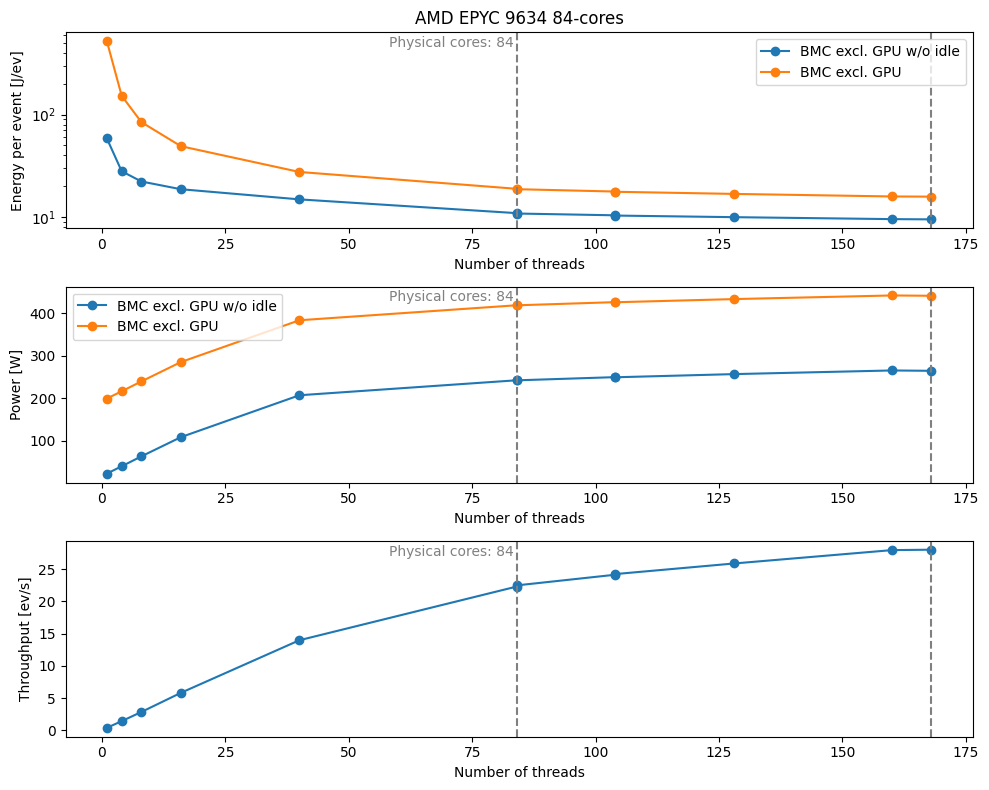

In [658]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))


ax1.plot(
    plot_df["cores"],
    plot_df["j_per_ev_bmc_no_gpu_wo_idle"],
    label="BMC excl. GPU w/o idle",
    marker="o",
)
ax1.plot(
    plot_df["cores"], plot_df["j_per_ev_bmc_no_gpu"], label="BMC excl. GPU", marker="o"
)
ax3.plot(
    plot_df["cores"],
    plot_df["throughput_events_slope_s"],
    label="Throughput [ev/s]",
    marker="o",
)

# ax2.fill_between(plot_df["cores"], plot_df["bmc_no_gpu_wo_idle_mean"] - plot_df["bmc_no_gpu_wo_idle_std"], plot_df["bmc_no_gpu_wo_idle_mean"] + plot_df["bmc_no_gpu_wo_idle_std"], alpha=0.5)
ax2.plot(
    plot_df["cores"],
    plot_df["bmc_no_gpu_wo_idle"],
    label="BMC excl. GPU w/o idle",
    marker="o",
)
# ax2.fill_between(plot_df["cores"], plot_df["bmc_no_gpu_mean"] - plot_df["bmc_no_gpu_std"], plot_df["bmc_no_gpu_mean"] + plot_df["bmc_no_gpu_std"], alpha=0.5)
ax2.plot(
    plot_df["cores"], plot_df["bmc_no_gpu"], label="BMC excl. GPU", marker="o"
)

ax1.set_ylabel("Energy per event [J/ev]")
ax1.set_yscale("log")
ax2.set_ylabel("Power [W]")
ax3.set_ylabel("Throughput [ev/s]")

J_per_kcal = 4184.0
kcal_bigmac = 500

f = 1e-6


ax1.legend()
ax2.legend()

for ax in (ax1, ax2, ax3):
    ax.set_xlabel("Number of threads")
    ax.axvline(84, color="gray", linestyle="--")
    ax.axvline(168, color="gray", linestyle="--")
    ax.text(
        s="Physical cores: 84",
        x=84 - 0.5,
        y=0.98,
        ha="right",
        va="top",
        transform=ax.get_xaxis_transform(),
        color="gray",
    )

ax1.set_title("AMD EPYC 9634 84-cores")

fig.tight_layout()
fig.savefig("j_per_ev_bmc_no_gpu_wo_idle.pdf")
plt.show()